In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

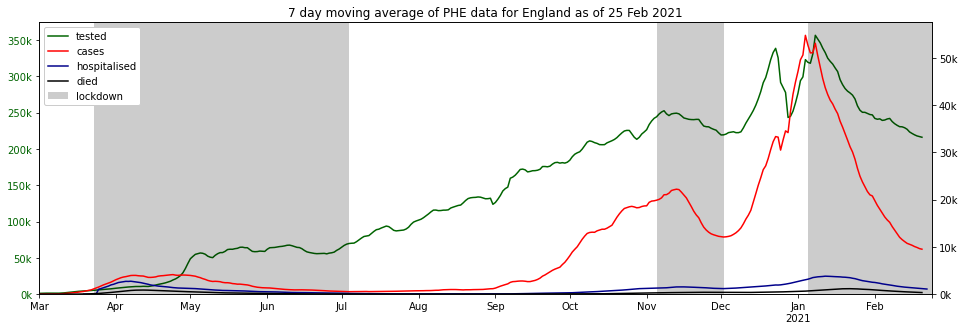

In [2]:
plot_summary(earliest_date='2020-03-01')

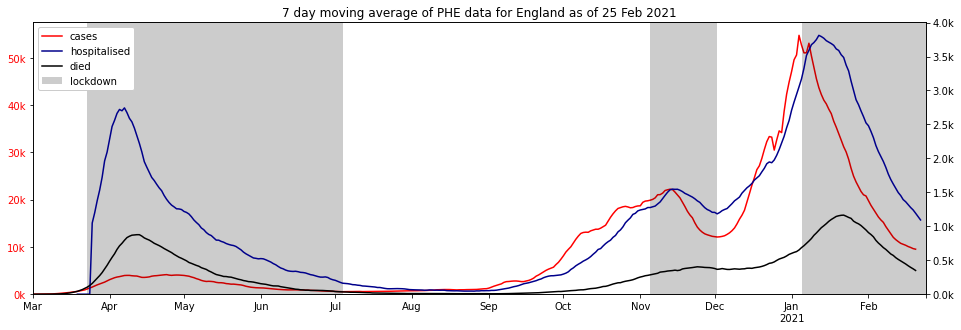

In [3]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,542569.0,15794992.0,15252423.0,56286961,0.963934,27.097613,71.938453
1,Northern Ireland,N92000002,31637.0,491593.0,459956.0,1893667,1.670674,24.289170,74.040156
2,Scotland,S92000003,56661.0,1515980.0,1459319.0,5463300,1.037120,26.711310,72.251570
3,Wales,W92000004,69851.0,889270.0,819419.0,3152879,2.215467,25.989548,71.794985


'partial: 18,691,835'

'full: 700,718'

66796807

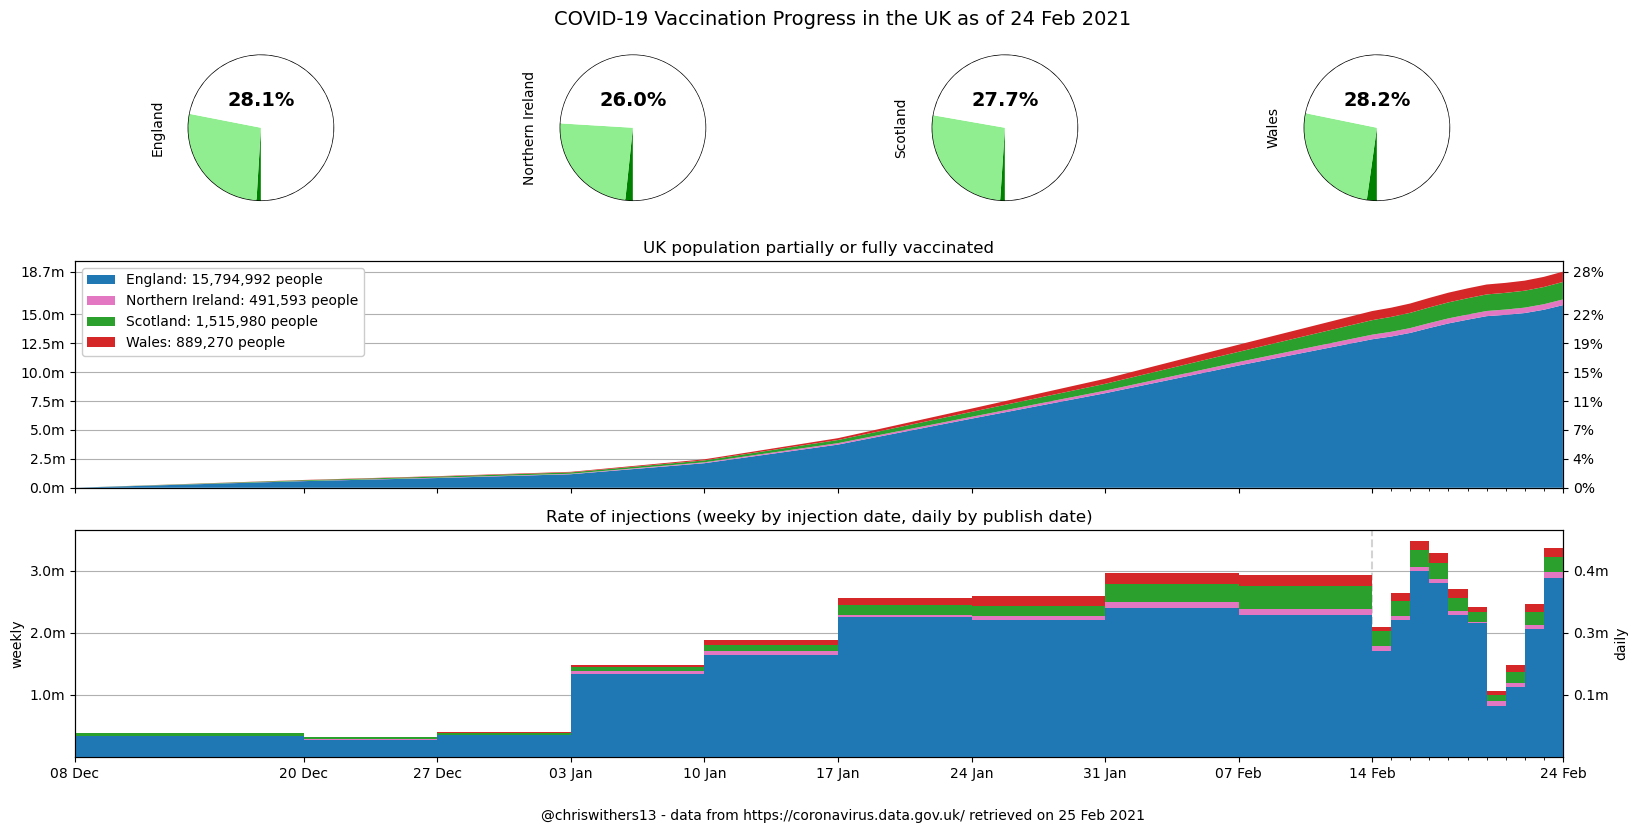

In [4]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}", results['population'].sum())

In [5]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,24 Feb 21,"+396,937","+14,209","+14,209","+15,794,992","+542,569","+542,569"
Northern Ireland,24 Feb 21,"+13,358",+292,+292,"+491,593","+31,637","+31,637"
Scotland,24 Feb 21,"+27,903","+6,540","+6,540","+1,515,980","+56,661","+56,661"
Wales,24 Feb 21,"+10,764","+10,572","+10,572","+889,270","+69,851","+69,851"


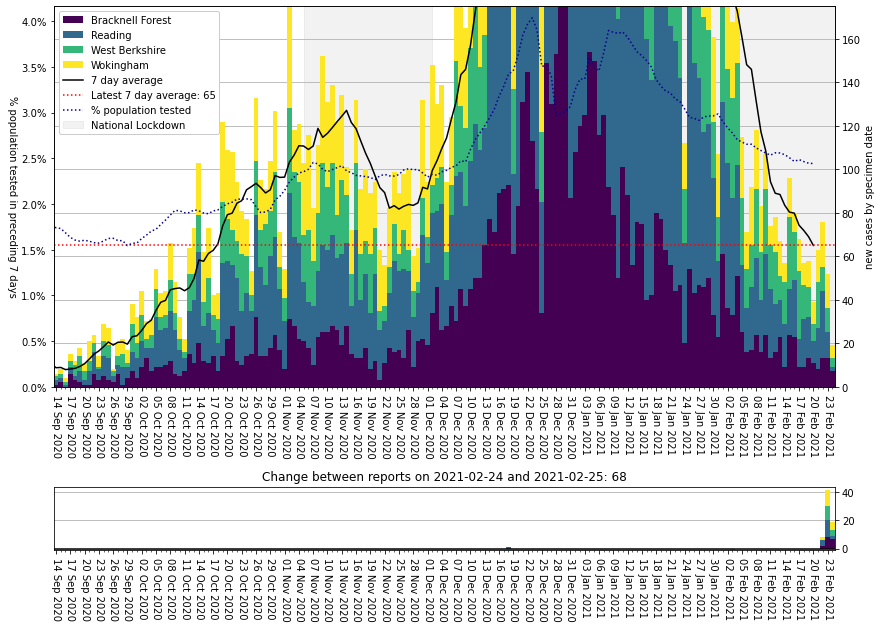

In [6]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=175)

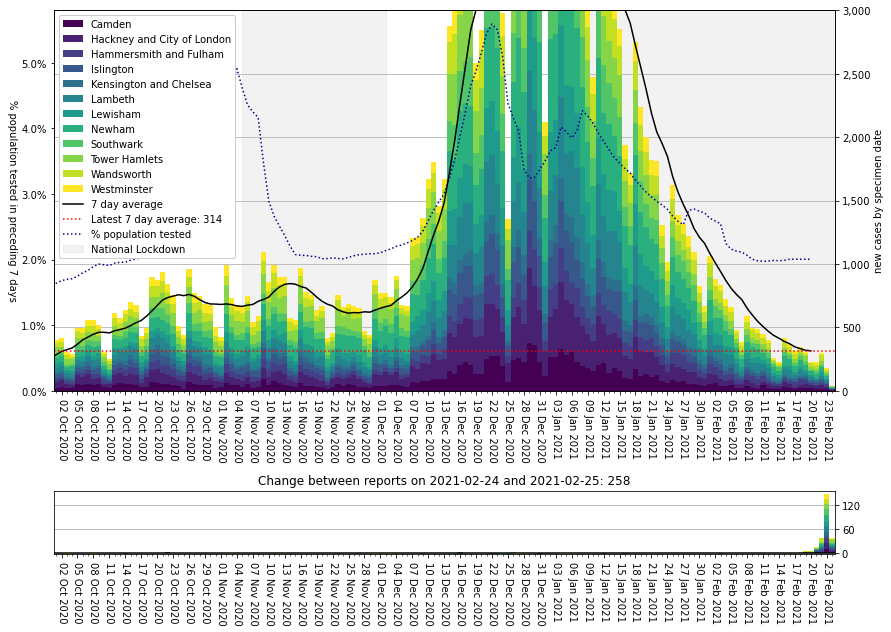

In [7]:
plot_areas(for_date, areas=london_areas, ylim=3_000)

In [8]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [9]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,265.861697,192.0,2021-02-24
E07000010,Fenland,202.258223,206.0,2021-02-24
E06000016,Leicester,201.002755,712.0,2021-02-24
E07000218,North Warwickshire,193.062025,126.0,2021-02-24
E06000031,Peterborough,187.383503,379.0,2021-02-24
E08000028,Sandwell,185.720810,610.0,2021-02-24
E07000199,Tamworth,185.146553,142.0,2021-02-24
E07000174,Mansfield,183.875660,201.0,2021-02-24
S12000014,Falkirk,175.896575,283.0,2021-02-24


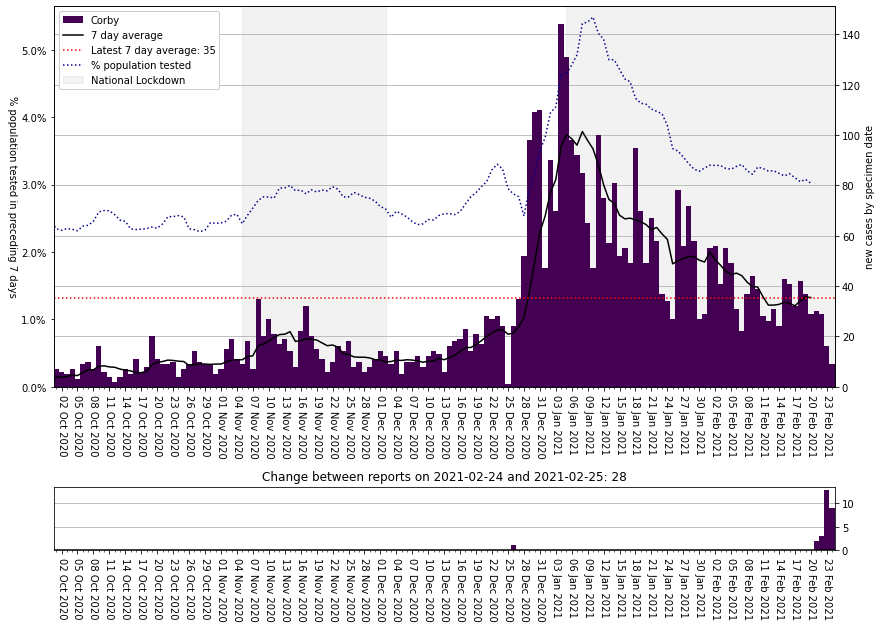

In [10]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [11]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,126.114891,1440.0,2021-02-24
E08000035,Leeds,136.419972,1082.0,2021-02-24
E08000032,Bradford,171.737906,927.0,2021-02-24
S12000049,Glasgow City,125.094769,792.0,2021-02-24
E06000016,Leicester,201.002755,712.0,2021-02-24
E08000003,Manchester,126.614791,700.0,2021-02-24
E08000034,Kirklees,153.256008,674.0,2021-02-24
E08000019,Sheffield,111.822971,654.0,2021-02-24
E08000028,Sandwell,185.720810,610.0,2021-02-24


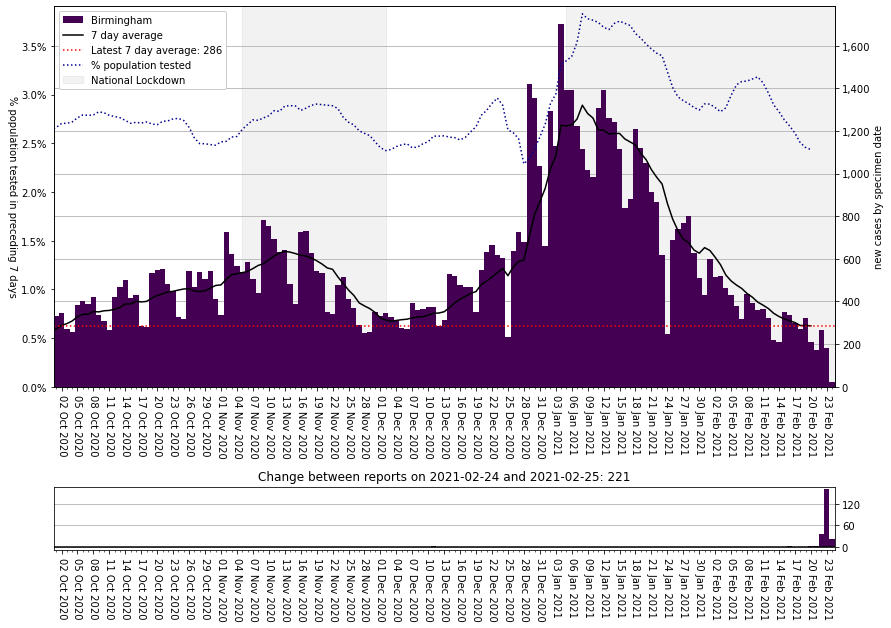

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [3]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.3
phe_max = 0.3

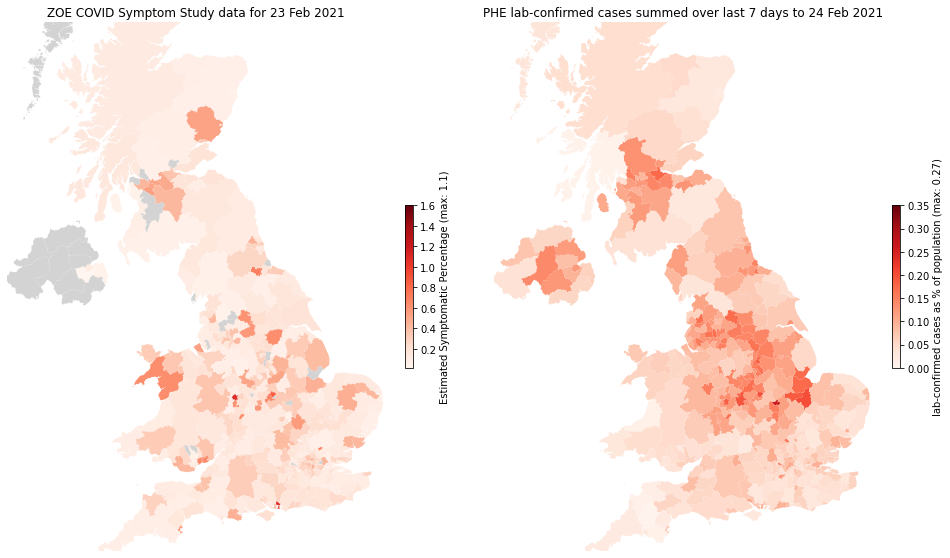

In [4]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [15]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...

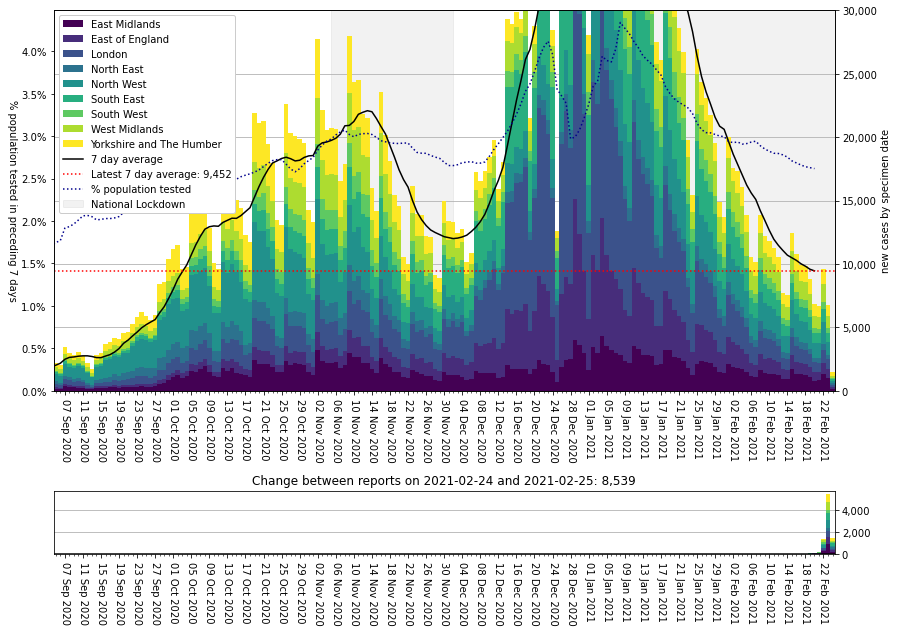

In [16]:
plot_areas(for_date, area_type=region, ylim=30_000, earliest='2020-09-05')

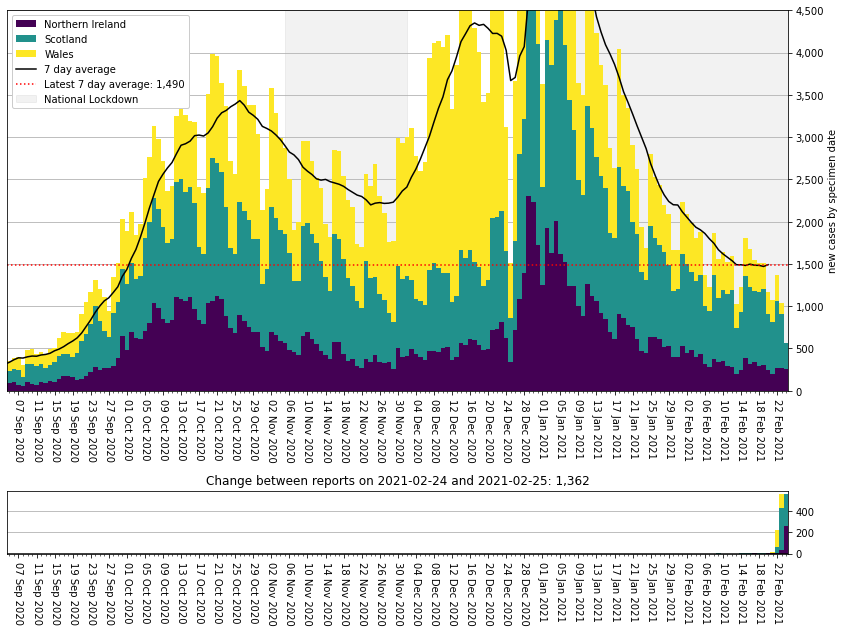

In [17]:
plot_areas(for_date, 'cases_devolved', ylim=4_500, diff_ylims=None, earliest='2020-09-05')